<a href="https://colab.research.google.com/github/maikramos1/PesquisaKaggle/blob/main/KaggleIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importação das bibliotecas necessárias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
!pip install --upgrade tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#Caminho do dataset
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("sumithsingh/blood-cell-images-for-cancer-detection")


#DATASET_PATH = '/kaggle/input/blood-cell-images-for-cancer-detection'

In [ ]:
#Definindo conjunto aleatório
SEED = 42
np.random.seed(SEED)

In [ ]:
#Lista de classes
CLASSES = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

In [ ]:
#Verificando a estrutura do dataset
for class_name in CLASSES:
    print(f"{class_name}: {len(os.listdir(os.path.join(DATASET_PATH, class_name)))} images")

basophil: 1000 images
erythroblast: 1000 images
monocyte: 1000 images
myeloblast: 1000 images
seg_neutrophil: 1000 images


In [ ]:
#Verificando se há arquivos ausentes ou corrompidos
for class_name in CLASSES:
    for img_file in os.listdir(os.path.join(DATASET_PATH, class_name)):
        try:
            img = cv2.imread(os.path.join(DATASET_PATH, class_name, img_file))
        except:
            print(f"Corrupt file: {img_file}")

In [ ]:
#Definindo o tamanho da imagem
IMG_HEIGHT, IMG_WIDTH = 128, 128

In [ ]:
#Inicialize matrizes vazias para dados e rótulos
####perguntar
images = []
labels = []

In [ ]:
#Carregar imagens nos arrays
for class_index, class_name in enumerate(CLASSES):
    folder_path = os.path.join(DATASET_PATH, class_name)
    for img_file in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, img_file))
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        images.append(img)
        labels.append(class_index)
images = np.array(images)
labels = np.array(labels)

In [ ]:
#Pré-processando os dados
images = images / 255.0

In [ ]:
#Convertendo rótulos pro formato categórico
labels = to_categorical(labels, num_classes=len(CLASSES))

In [ ]:
#Divizão dos dados em conjuntos de validação de treino e teste
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

In [ ]:
#Inicializando o gerador de dados de imagem para aumentadas
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

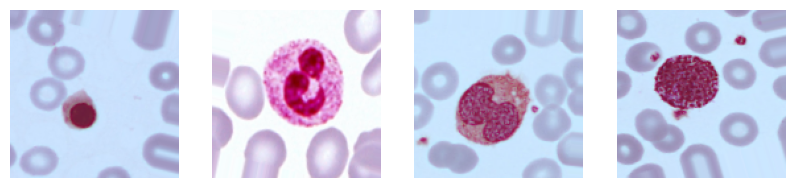

In [ ]:
#Exibindo imagens aumentadas
augmented_images = next(datagen.flow(X_train, y_train, batch_size=4))
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
for i, img in enumerate(augmented_images[0]):
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

In [ ]:
#Construção e treinamento do modelo (onde a mágica acontece)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASSES), activation='softmax')
])

In [ ]:
#Compilação do modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Exibindo sumário do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,213 (24.87 MB)

 Trainable params: 6,517,765 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#Treinando o modelo
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    steps_per_epoch=len(X_train) // 32
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7053 - loss: 2.5988 - val_accuracy: 0.1973 - val_loss: 12.3767
Epoch 2/20
  1/109 ━━━━━━━━━━━━━━━━━━━━ 1:43 954ms/step - accuracy: 0.9062 - loss: 0.5799

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.9062 - loss: 0.5799 - val_accuracy: 0.1973 - val_loss: 12.1588
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.8981 - loss: 0.5351 - val_accuracy: 0.1973 - val_loss: 12.6560
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 0.1973 - val_loss: 13.0639
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9169 - loss: 0.3811 - val_accuracy: 0.5093 - val_loss: 2.6577
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.8750 - loss: 0.5978 - val_accuracy: 0.5280 - val_loss: 2.6392
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9385 - loss: 0.2338 - val_accuracy: 0.6333 - val_loss: 1.1581
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.9688 - loss: 1.0308 - val_accuracy: 0.6307 - val_loss: 1.0877
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9431 - loss: 0.2045 - val_accuracy:

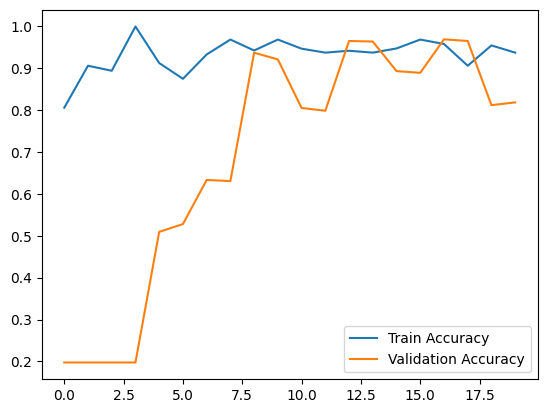

In [ ]:
#Exibindo performance do treino
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
#Avaliação e desenvolvimento
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.8166 - loss: 0.7794
Test Accuracy: 0.83


In [ ]:
#Gerando previsões
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step


In [ ]:
#Exibindo relatório de classificação
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

                precision    recall  f1-score   support

      basophil       0.56      1.00      0.72       157
  erythroblast       1.00      0.76      0.87       161
      monocyte       0.92      0.35      0.50       142
    myeloblast       0.99      1.00      1.00       153
seg_neutrophil       0.98      1.00      0.99       137

      accuracy                           0.83       750
     macro avg       0.89      0.82      0.81       750
  weighted avg       0.89      0.83      0.82       750



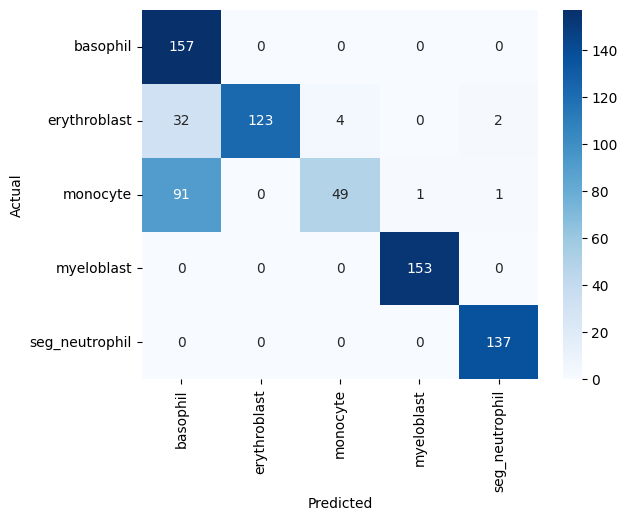

In [ ]:
#Exibindo a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Salvando o modelo de treino
model.save('my_model.keras')

In [ ]:
#Carregando o modelo salvo
from tensorflow.keras.models import load_model
loaded_model = load_model('my_model.keras')

In [ ]:
#Testando com uma nova imagem
IMAGE_PATH = os.path.join(DATASET_PATH, "erythroblast", "ERB_101031.jpg")

img = cv2.imread(IMAGE_PATH)
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) / 255.0
img = np.expand_dims(img, axis=0)
prediction = np.argmax(loaded_model.predict(img))
print(f"Predicted Class: {CLASSES[prediction]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Predicted Class: erythroblast


In [ ]:
#Carregando e pré-processando a imagem
import matplotlib.pyplot as plt

img_path = os.path.join(DATASET_PATH, "seg_neutrophil", "NGS_0022.jpg")
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) / 255.0
img_expanded = np.expand_dims(img_resized, axis=0)

In [ ]:
#Fazendo previsão
predictions = loaded_model.predict(img_expanded)
predicted_class = np.argmax(predictions)
confidence = predictions[0][predicted_class] * 100  # convertendo pra porcentagem

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


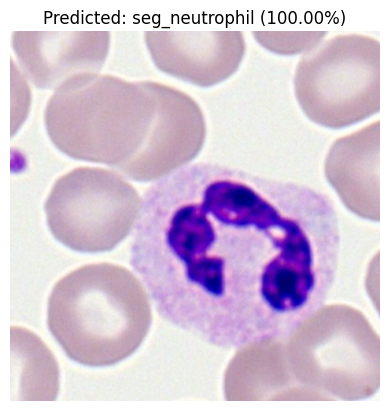

In [ ]:
#Exibe a imagem predicada
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted: {CLASSES[predicted_class]} ({confidence:.2f}%)")
plt.show()

In [ ]:
#Exibe a saída detalhada
print(f"Predicted Class: {CLASSES[predicted_class]}")
print(f"Confidence: {confidence:.2f}%")

Predicted Class: seg_neutrophil
Confidence: 100.00%
